# Baseline model

This notebook is an adaptation of the `segment_aerial_images.ipynb` notebook that was provided to in the [CS-443 course GitHub](https://github.com/epfml/ML_course/blob/master/projects/project2/project_road_segmentation/segment_aerial_images.ipynb).

It is used to train a simpler baseline models (LogisticRegression, XGBoost) to compare against the more advanced models that we use in our project.

In [32]:
import sklearn.metrics
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

In [33]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

In [34]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('baseline_model.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

In [35]:
# Helper functions


def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

In [36]:
# Loaded a set of images
#root_dir = "training/"
root_dir = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

image_dir = os.path.join(root_dir, 'images')
files = os.listdir(image_dir)
n = min(80, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
#imgs = [load_image(image_dir + files[i]) for i in range(n)]
imgs = [load_image(os.path.join(image_dir, files[i])) for i in range(n)]
print(files[0])

gt_dir = os.path.join(root_dir, 'masks')
print("Loading " + str(n) + " images")
#gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
gt_imgs = [load_image(os.path.join(gt_dir, files[i])) for i in range(n)]
print(files[0])

n = 10  # Only use 10 images for training

Loading 80 images
satImage_058.png
Loading 80 images
satImage_058.png


Image size = 400,400


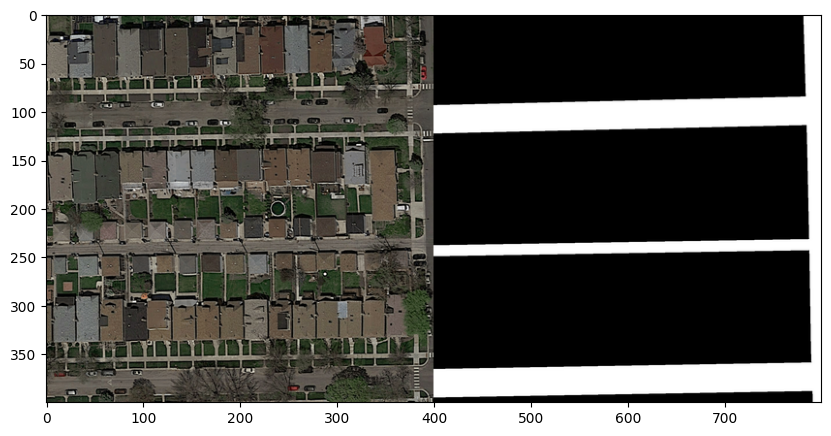

In [37]:
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

In [38]:
# Extract patches from input images
patch_size = 16  # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

In [39]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0, 1))
    feat_v = np.var(img, axis=(0, 1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray(
        [extract_features(img_patches[i]) for i in range(len(img_patches))]
    )
    return X

In [40]:
from sklearn.model_selection import train_test_split

# Compute features for each image patch
foreground_threshold = (
    0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
)


def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0


X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=66)

## Train Logistic Regression model

In [44]:
from sklearn import linear_model

models = {}

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X_train, y_train)

models["LogisticRegression"] = logreg

## Train sklearn GradientBoosting model

In [45]:
from sklearn import ensemble

gdboost = ensemble.GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=10, random_state=0)
gdboost.fit(X_train, y_train)

models["GradientBoostingClassifier"] = gdboost


## Train XGBoost model

In [46]:
from flaml import AutoML

# Automl performs search for the best model
automl = AutoML()
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune XGBoost in this example
    "task": 'classification',  # task type
    "seed": 7654321,  # random seed
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

models["XGBoost"] = automl

[flaml.automl.logger: 12-12 15:29:58] {1679} INFO - task = classification
[flaml.automl.logger: 12-12 15:29:58] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 12-12 15:29:58] {1788} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-12 15:29:58] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-12 15:29:58] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-12 15:29:58] {2344} INFO - Estimated sufficient time budget=682s. Estimated necessary time budget=1s.
[flaml.automl.logger: 12-12 15:29:58] {2391} INFO -  at 0.1s,	estimator xgboost's best error=0.2228,	best estimator xgboost's best error=0.2228
[flaml.automl.logger: 12-12 15:29:58] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-12 15:29:58] {2391} INFO -  at 0.1s,	estimator xgboost's best error=0.2228,	best estimator xgboost's best error=0.2228
[flaml.automl.logger: 12-12 15:29:58] {2218} INFO - iteration 2, current learne

In [47]:
# Convert array of labels to an image


def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img


Model: LogisticRegression
f1 score is 0.398
True positive rate = 0.146
accuracy score is 0.557

Model: GradientBoostingClassifier
f1 score is 0.455
True positive rate = 0.086
accuracy score is 0.793

Model: XGBoost
f1 score is 0.373
True positive rate = 0.062
accuracy score is 0.79


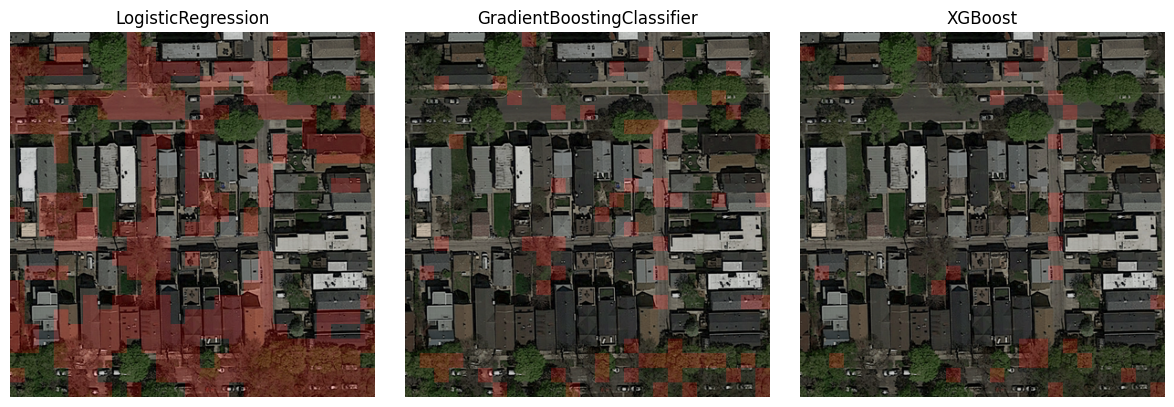

In [56]:
from sklearn.metrics import f1_score, accuracy_score

fig = plt.figure(layout='tight', figsize=(12, 4))

for i, (name, model) in enumerate(models.items()):
    print(f"\nModel: {name}")
    
    # Predict on the training set
    Z = model.predict(X_test)
    
    # Get non-zeros in prediction and grountruth arrays
    Zn = np.nonzero(Z)[0]
    Yn = np.nonzero(y_test)[0]
    
    # Print scores
    f1 = f1_score(y_test, Z, zero_division='warn')
    print(f"f1 score is {round(f1, 3)}")
    TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
    print("True positive rate = " + str(round(TPR, 3)))
    accuracy = accuracy_score(y_test, Z)
    print(f"accuracy score is {round(accuracy, 3)}")
    
    
    #### Show prediction on example image
    # Read picture and predict
    img_idx = 12
    Xi = extract_img_features( os.path.join(image_dir, files[img_idx]))
    Zi = model.predict(Xi)
    
    # Create prediction overlay
    w = gt_imgs[img_idx].shape[0]
    h = gt_imgs[img_idx].shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    new_img = make_img_overlay(imgs[img_idx], predicted_im)
    
    # Add image to figure
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(new_img)
    ax.set_title(name)
    ax.axis("off")